[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/probabilistic_python/blob/master/mcmc.ipynb)

# MCMC in PyMC

Though it provides several tools for Bayesian inference, PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

Let's take a closer look at MCMC sampling in PyMC, motivating it with a new example:

In [18]:
#import aesara.tensor as at
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


random_seed = 42
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/probabilistic_python/master/data/"

## Example: Six Nations Rugby Matchups

The Six Nations Championship is one of the world's great rugby tournaments, with the six top rugby nations in Europe competing each year: England, Wales, Scotland, Ireland, France, and Italy.

![](assets/six-nations.png)

We may be interested in building a model that predicts the outcome of matches between any two teams, based on past performances. We know that Ireland is better than Italy, but how much better?

One approach is to build a **latent variable model** that describes the strength of a team based on their propensity for scoring or givin up points.

In [19]:
try:
    rugby_data = pd.read_csv("data/rugby.csv", index_col=0)
except FileNotFoundError:
    rugby_data = pd.read_csv(DATA_URL + 'rugby.csv', index_col=0)
rugby_data.head()

,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014


## The model

The league is made up by a total of $T= 6$ teams, playing each other once in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season as $y_{g1}$ and $y_{g2}$ respectively. 

The vector of observed points $y_{g} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:

$$y_{gj} \sim \text{Poisson}(\theta_{gj})$$

where the theta parameters represent the scoring intensity in the g-th game for the team playing at home and away, $j=1$ and $j=2$ respectively.

To ensure that the Poisson rate is positive, we will build a model using a **log-linear** formulation. The home team's expected score is then given by:

$$\log(\theta_{g1}) = \eta + \alpha_{h[g]} + \delta_{a[g]}$$

The parameter $\alpha_{h[g]}$ is the attacking skill of the home team in game $g$, while $\delta_{a[g]}$ is the defensive skill of the away team in the same game.

$\eta$ represents the home advantage, which for simplicity we assume is constant for all teams during the season.

To aid interpretaiton, let's reparameterize this model slightly; specifically, we will constrain the team offensive and defensive skills to sum to zero, and include an intercept term that describes the expected score of an average team (excluding the home advantage).

$$\log(\theta_{g1}) = \mu + \eta + \alpha^*_{h[g]} + \delta^*_{a[g]}$$

where 

$$\alpha^*_t = \alpha_t - \bar{\alpha.}$$

$$\delta^*_t = \delta_t - \bar{\delta.}$$


Correspondingly, the away team's expected score is:

$$\log(\theta_{g2}) = \mu + \alpha^*_{a[g]} + \delta^*_{h[g]}$$

Given this formulation, we will need indices for all of the teams, in order to extract the appropriate parameters for each game. 

The pandas `factorize` function is useful here.

In [20]:
home_idx, teams = pd.factorize(rugby_data["home_team"], sort=True)
away_idx, _ = pd.factorize(rugby_data["away_team"], sort=True)

Though it has been available in later PyMC3 versions, a relatively new feature is the ability to specify variable dimensions using categorical labels. These can be passed to the model in a `dict` called `coords`.

In [21]:
coords = {"team": teams}

To make it easier to generate predictions with our model, we will make our inputs **mutable**. It creates symbolic variables in the model, which can be changed after the model is fit.

In [22]:
with pm.Model(coords=coords) as rugby_model:

    home_team = pm.Data("home_team", home_idx)
    away_team = pm.Data("away_team", away_idx)


Next, we specify the priors for the latent variables in our model. This includes the scoring mean, the home team effect, and the vector of team strengths on offense and defense.

In [23]:
with rugby_model:

    eta = pm.Normal("eta", mu=1, sigma=1)

    mu = pm.Normal('mu', 3, sigma=1)

    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="team")
    delta = pm.Normal("delta", mu=0, sigma=1, dims="team")

Next, we will constrain the offense and defense skills to sum to zero, but dividing by the means of each vector of parameters.

In [24]:
with rugby_model:

    alpha_star = pm.Deterministic("alpha_star", alpha - pt.mean(alpha), dims="team")  
    delta_star = pm.Deterministic("delta_star", delta - pt.mean(delta), dims="team")  

The expected values for the home and away teams in each game can then be calculated as:

In [25]:
with rugby_model:

    home_theta = pt.exp(mu + eta + alpha_star[home_team] + delta[away_team])
    away_theta = pt.exp(mu + alpha[away_team] + delta[home_team])

Finally, the likelhoods of the observed scores.

In [26]:
with rugby_model:

    home_score = pm.Poisson(
        "home_score",
        mu=home_theta,
        observed=rugby_data["home_score"].values
    )
    away_score = pm.Poisson(
        "away_score",
        mu=away_theta,
        observed=rugby_data["away_score"].values
    )


That's it! Let's take a peek at the graph of the model. This is an easy visual check to ensure that the model has been constructed as intended.

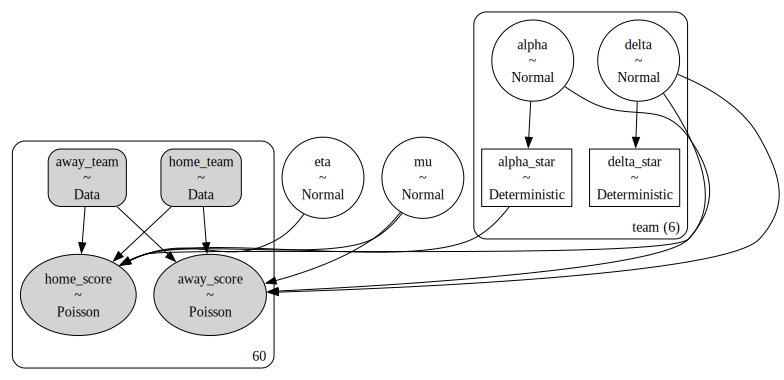

In [27]:
pm.model_to_graphviz(rugby_model)

For convenience, below is the entire model in a single cell, wrapped in a function so that we can instantiate it as needed:

In [28]:
def create_rugby_model():

    with pm.Model(coords=coords) as m:

        # Data inputs
        home_team = pm.MutableData("home_team", home_idx)
        away_team = pm.MutableData("away_team", away_idx)

        # Average score (log scale)
        mu = pm.Normal('mu', 3, sigma=1)

        # Home field effect
        eta = pm.Normal("eta", mu=1, sigma=1)

        # Team attack and defense skills
        alpha = pm.Normal("alpha", mu=0, sigma=1, dims="team")
        delta = pm.Normal("delta", mu=0, sigma=1, dims="team")

        # Centered skills
        alpha_star = pm.Deterministic("alpha_star", alpha - pt.mean(alpha), dims="team")  
        delta_star = pm.Deterministic("delta_star", delta - pt.mean(delta), dims="team")  
        
        # Expected home and away scores for each game
        home_theta = pt.exp(mu + eta + alpha_star[home_team] + delta[away_team])
        away_theta = pt.exp(mu + alpha[away_team] + delta[home_team])

        # Likelihood functions
        home_score = pm.Poisson(
            "home_score",
            mu=home_theta,
            observed=rugby_data["home_score"].values
        )
        away_score = pm.Poisson(
            "away_score",
            mu=away_theta,
            observed=rugby_data["away_score"].values
        )

    return m

Now it's time to fit the model with MCMC.

## `sample`

The user's interface to PyMC's sampling algorithms is the `sample` function. There is a large set of input parameters, all of which are optional with reasonable defaults, but here are the most common ones that you may want to modify:

```python
def sample(
    draws: int = 1000,
    step=None,
    init: str = "auto",
    n_init: int = 200_000,
    initvals: Optional[Union[StartDict, 
        Sequence[Optional[StartDict]]]] = None,
    trace: Optional[Union[BaseTrace, List[str]]] = None,
    chain_idx: int = 0,
    chains: Optional[int] = None,
    cores: Optional[int] = None,
    tune: int = 1000,
    ...
)
```

`sample` assigns particular samplers to model variables, and generates samples from them. 

PyMC can automate most of the details of sampling using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

Most commonly, the `draws` argument that 
controls the total number of MCMC iterations and the `tune` argument that controls the number of additional tuning steps to perform, are modified by the user depending on the model being fit.

### Assigning sampling algorithm

The `step` argument allows users to manually assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with rugby_model:

    trace = pm.sample(1000, step=pm.Metropolis())
```

or if we only wanted to assign `Metropolis` to a subset of our parameters:

```python
with rugby_model:

    trace = pm.sample(1000, step=pm.Metropolis(vars=[alpha, delta]))
```

When `step` is not specified by the user, PyMC will assign step methods to variables automatically. To do so, each step method implements a class method called `Competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample()` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `initvals` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. 

If starting values are not passed by the user (`intivals=None`), default values are chosen from the mean, median or mode of the distribution.

In [29]:
rugby_model.initial_values

AttributeError: 'Model' object has no attribute 'initial_values'

In [30]:
with create_rugby_model():

    initval_trace = pm.sample(draws=500, tune=0, step=pm.Metropolis(), initvals={'eta':-1})

c:\Users\nazmievairat\anaconda3\envs\pymc_env\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [eta]
>Metropolis: [alpha]
>Metropolis: [delta]


Output()

Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The ArviZ function `plot_trace` is a useful exploratory tool for examining the resulting samples, which we refer to as a *trace*. On the left is a set of histograms (one for each chain) and on the right is a time series plot of the chains in the order they were drawn.

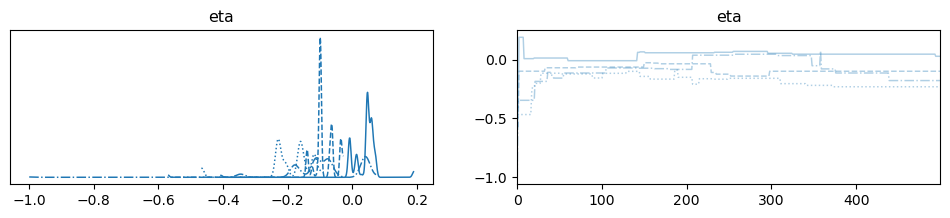

In [31]:
az.plot_trace(initval_trace, var_names=["eta"]);

This example was deliberately poor, showing the movement away from the initial values, but each of the chains appear to be stuck in different regions of the parameter space. This model needs tuning!

Let's tune the model and generate some results ...

In [32]:
with rugby_model:

    trace = pm.sample(1000, tune=1000, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, alpha, delta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


You likely saw some warnings after running the model as specified above. We will dig into these warnings a bit later.

Let's have a peek at some of the parameters of interest. The [ArviZ](https://github.com/arviz-devs/arviz) package allows us to easily plot the posterior estimates. Below is a *forest plot* of the attacking strengths:

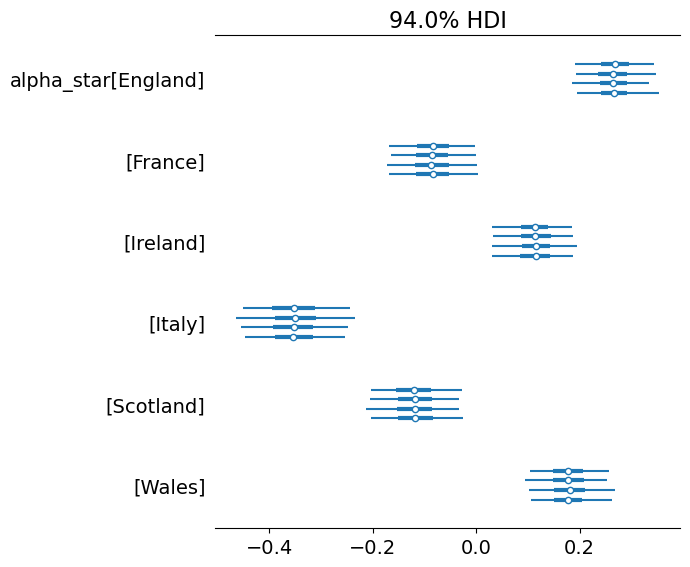

In [33]:
az.plot_forest(trace, var_names=["alpha_star"]);

Depending on which system you ran the model on, you likely see 2-4 lines per team parameter. These are the posterior highest density interval (HDI, thin line) and interquartile range (thick line), along with the posterior mean (open dot) for each chain. 

This graphic shows that Italy has the weakest offense, with England having the strongest (though with some overlap with Ireland and Wales).

Below is the corresponding plot for the defenses:

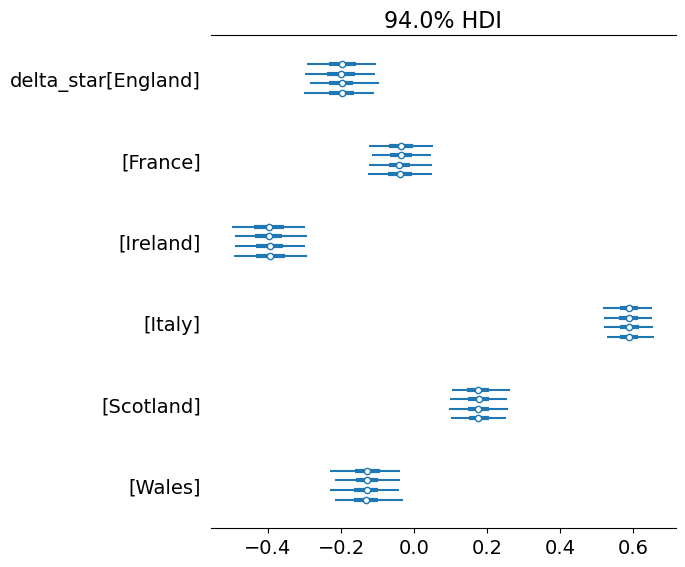

In [34]:
az.plot_forest(trace, var_names=["delta_star"]);

For univariate variables, a *posterior plot* can be used to inspect the posterior distribution.

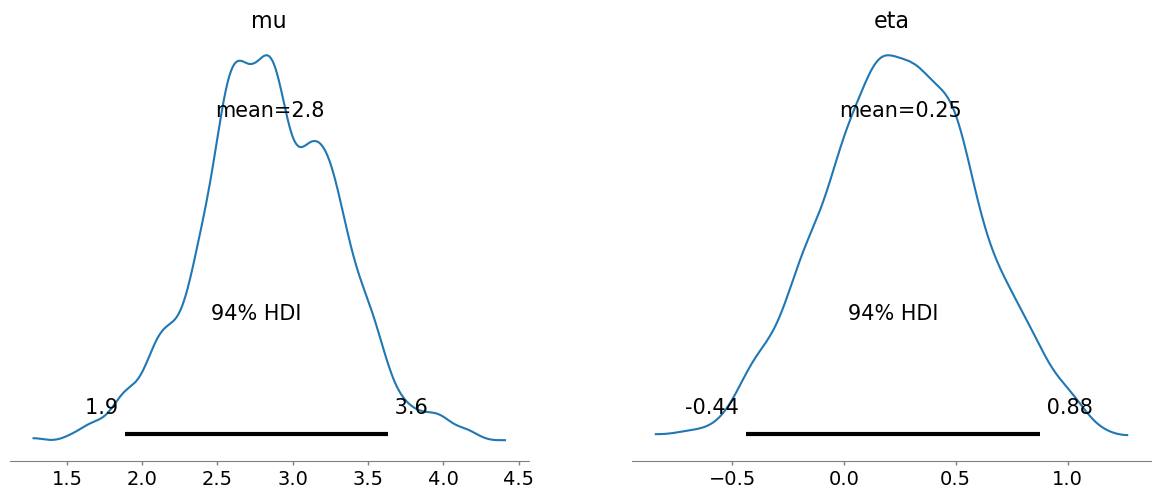

In [35]:
az.plot_posterior(trace, var_names=["mu", "eta"]);

Remember, these parameters are on the log scale, so the estimates correspond to an expectation of:

In [36]:
np.exp(2.8)

np.float64(16.444646771097048)

points for away teams and 

In [37]:
np.exp(2.8+0.24)

np.float64(20.905243235092758)

points for home teams.

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [38]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

This `InferenceData` object is a data structure that stores the samples from an MCMC run as grouped attributes. The data structure itself is an `xarray.Dataset` object, which is a dictionary-like object that stores the samples in a multi-dimensional array.

The xarray components include:

- **Data variables** are the actual values generated from the MCMC draws
- **Dimensions** are the axes on which refer to the data variables
- **Coordinates** are pointers to specific slices or points in the `xarray.Dataset`

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

In [39]:
with rugby_model:
    ptrace = pm.sample(100, chains=6, cores=4, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [eta, mu, alpha, delta]


Output()

Sampling 6 chains for 1_000 tune and 100 draw iterations (6_000 + 600 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running $n$ iterations with $c$ chains will result in $c \times n$ samples.

In [ ]:
ptrace.posterior['alpha'].shape

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.


# Model Checking

After running an MCMC simulation, `sample` returns an `arviz.InferenceData` object containing the samples for all the stochastic and named deterministic random variables. The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid. There are two components to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect lack of convergence in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. The second component of model checking, goodness of fit, is used to check the internal validity of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

### Gazing at Sample Trace

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for any of the stochastic variables displays lack of stationarity or homogeneity, this may be evidence of lack of convergence.

In [ ]:
with create_rugby_model():

    bad_trace = pm.sample(1000, tune=10, chains=2, random_seed=random_seed)

In [ ]:
az.plot_trace(bad_trace, var_names=['eta', 'mu'], backend_kwargs=dict(constrained_layout=True));

In comparison, here are traces from the full run with 1000 samples after 1000 tuning iterations.

In [ ]:
az.plot_trace(trace, var_names=['eta', 'mu'], backend_kwargs=dict(constrained_layout=True));

### Divergences

During some of the MCMC runs above, you may have noticed warnings about divergnces:

    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.

You will see these divergences identified in the output of `plot_trace` as black lines along the x-axis.

Hamiltonian Monte Carlo (and NUTS) performs numerical integration in order to explore the posterior distribution of a model. When the integration goes wrong, it can go dramatically wrong.

For example, here are some Hamiltonian trajectories on the distribution of two correlated variables. Can you spot the divergent path?

![](assets/diverging_hmc.png)

The reason that this happens is that there may be parts of the posterior which are hard to explore for geometric reasons. Two ways of solving divergences are

1. **Set a higher `target accept` rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration, but result in longer run times.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do that. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. 
   
   
You should be wary of a trace that contains many divergences (particularly those clustered in particular regions of the parameter space), and attempt to fix them.

### Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies **how well momentum resampling matches the marginal energy distribution**. 

$$\text{BFMI} = \frac{\mathbb{E}_{\pi}[\text{Var}_{\pi_{E|q}}(E|q)]}{\text{Var}_{\pi_{E}}(E)}$$

$$\widehat{\text{BFMI}} = \frac{\sum_{i=1}^N (E_n - E_{n-1})^2}{\sum_{i=1}^N (E_n - \bar{E})^2}$$

A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to *efficiently* explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal. Reparameterizing the model is sometimes helpful for improving this statistic.

In [ ]:
az.bfmi(trace)

Another way of diagnosting this phenomenon is by comparing the *overall distribution of energy levels* with the *change of energy between successive samples*. Ideally, they should be very similar.

If the distribution of energy transitions is narrow relative to the marginal energy distribution, this is a sign of inefficient sampling, as many transitions are required to completely explore the posterior. On the other hand, if the energy transition distribution is similar to that of the marginal energy, this is evidence of efficient sampling, resulting in near-independent samples from the posterior.

In [ ]:
az.plot_energy(trace);

Bad energy plots are obvious, with the marginal energy distribution being much broader than the energy transition distribution.

In [ ]:
az.plot_energy(bad_trace);

### Potential Scale Reduction: $\hat{R}$

Roughly, $\hat{R}$ (*R-Hat*, or the *potential scale reduction factor*) is the ratio of between-chain variance to within-chain variance. This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

$\hat{R}$ uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, $\hat{R}$ monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the **potential scale reduction**, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. 

In ArViZ, the `summary` table, or a `plot_forest` with the `r_hat` flag set, will calculate $\hat{R}$ for each stochastic node in the trace.

In [ ]:
az.summary(trace)


## Goodness of Fit

As noted at the outset, convergence diagnostics are only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model to converge to something, so additional steps are needed to ensure that the estimated model adequately fits the data. 

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from the discussion on prediction, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is easy in PyMC. The `sample_posterior_predictive` function draws posterior predictive samples from all of the observed variables in the model.

The posterior predictive distribution of rugby scores uses the same functional form as the data likelihood, in this case a Poisson stochastic. Here is the corresponding sample from the posterior predictive distribution (we typically need very few samples relative to the MCMC sample):

In [ ]:
with rugby_model:

    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

This generates draws that account both for the residual posterior uncertainty of the model parameters and the stochastic variability of the sampling distribution.

Setting the `extend_inferencedata` flag will append the resulting samples to the trace that is passed in, adding a `posterior_predictive` node to the trace.

In [ ]:
trace

It is easiest to evaluate the calibration of the model visually, using the `plot_ppc` function. This plots the posterior predictive samples (and the mean prediction) relative to the observed data.

In [ ]:
az.plot_ppc(trace, kind='cumulative');

## Making Predictions

Now that we are (mostly) happy with the state of the fitted model, we can use it to make predictions.

If you recall from the original model specification, we created `MutableData` variables for the input data of home and away teams for each of the matches played. 

In [ ]:
pm.model_to_graphviz(rugby_model)

Since these variables are nodes in the underlying Aesara graph, we can swap in new data for for matchups we wish to predict. The `set_data` function allows us to do this.

In [ ]:
home_team = 'England'
away_team = 'Wales'

with rugby_model:

    pm.set_data({
        "home_team": np.where(teams == home_team)[0],
        "away_team": np.where(teams == away_team)[0],
    })

    pred = pm.sample_posterior_predictive(trace)

In [ ]:
away_pred = pred.posterior_predictive['away_score'].values.flatten()
home_pred = pred.posterior_predictive['home_score'].values.flatten()

In [ ]:
sns.kdeplot(away_pred, label=f"{away_team} (away)");
sns.kdeplot(home_pred, label=f"{home_team} (home)");
plt.legend();

In [ ]:
(home_pred > away_pred).mean()

---

## To Learn More

- **Peadar Coyle**'s [A Hierarchical Model for Rugby Prediction](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html) example notebook on the PyMC website.
- **Michael Betancourt**'s [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)
- **Hoffman, M. D., and A. Gelman. (2014)**. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.
- [Hamiltonian Monte Carlo from Scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/), by **Colin Carroll**
- **Gelman, A., & Rubin, D. B.** (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.
- **Abril, O.** (2019). [LOO-PIT Tutorial](https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/2019/07/31/loo-pit-tutorial.html)

A new course from [PyMC Labs](https://pymc-labs.io)!

![](assets/inutitive_bayes.png)